In [2]:
import os
import numpy as np
import glob
from tqdm import tqdm
import copy
from skimage.feature import canny
from skimage.transform import resize
import pandas as pd
import seaborn as sns
import nibabel as nib

# from torchinfo import summary

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torchio as tio
import networks_gan
import losses
from skimage.metrics import structural_similarity as ssim
from dataloader import RadOncTrainingDataset, RadOncValidationDataset, RadOncSynthesisDataset, headscanner_training_dataset, headscanner_validation_dataset
import surface_distance
from helpers import compute_surface_metrics, compute_TRE
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm  # nopep8

import matplotlib.pyplot as plt
from matplotlib import colors as mplcolors
from matplotlib.collections import LineCollection
def colormap_binary(fg, bg=(0,0,0), alpha=None):
    fg = mplcolors.to_rgb(fg)
    bg = mplcolors.to_rgb(bg)
    cmap = mplcolors.LinearSegmentedColormap.from_list('Binary', (bg,fg), 256)
    if alpha is not None:
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, alpha, cmap.N+3)
    return cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

2023-11-01 16:50:05.755597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 16:50:05.925890: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-01 16:50:05.929334: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-01 16:50:05.929349: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
valid_dataset = RadOncValidationDataset("/mnt/blackhole-data2/RadOnc_Brain/Validation", num_samples=None, supervision=True,
                                            return_segmentation=True)

device = torch.device('cpu')

In [4]:
G = networks_gan.JSRCascade(separate_decoders=True, res=True, version='v3').to(device)
checkpoint = torch.load('JSRCascade_l1100_multi0.3_reg100_seg0_ep109.pt', map_location=torch.device('cpu'))
G.load_state_dict(checkpoint['G_state_dict'])

/home/myi16/anaconda3/envs/jsr_Y/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

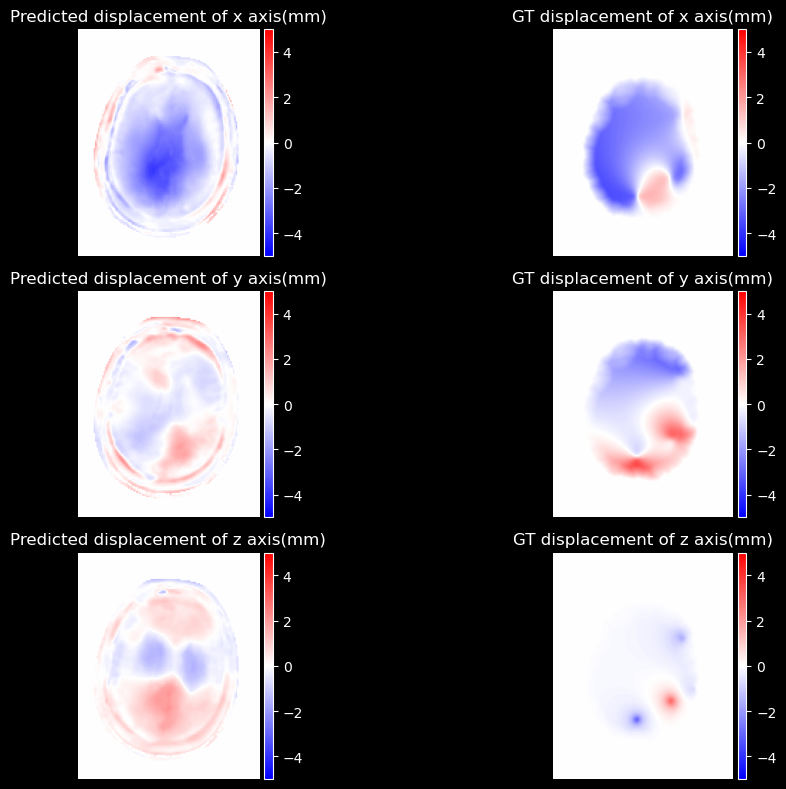

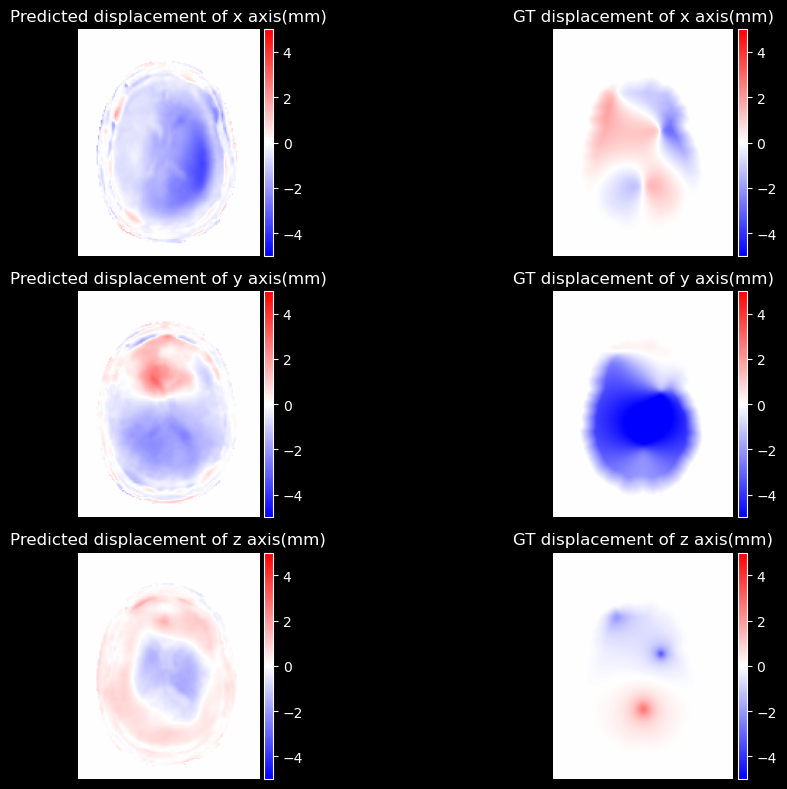

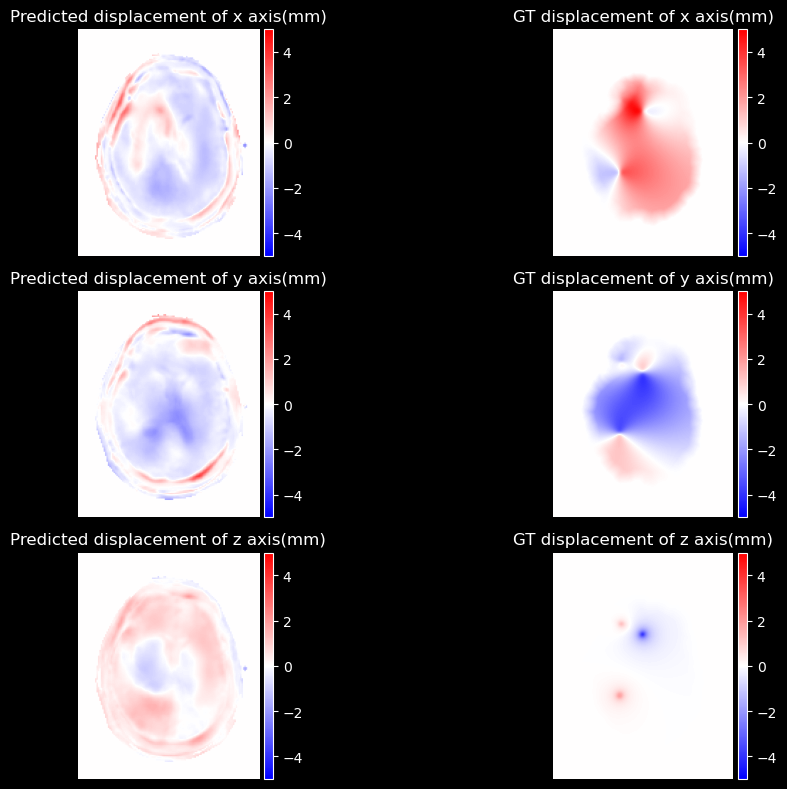

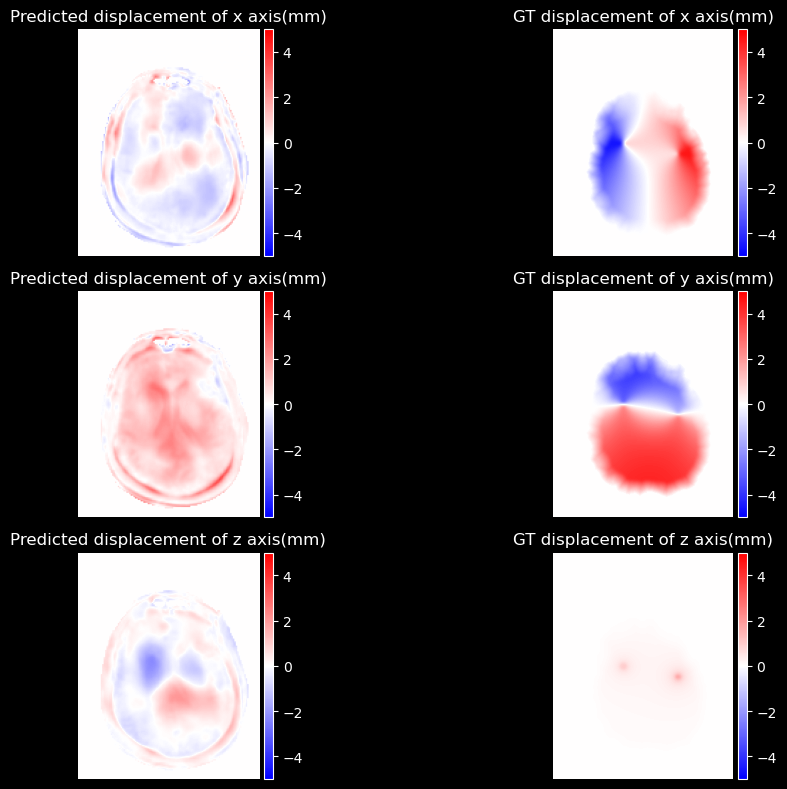

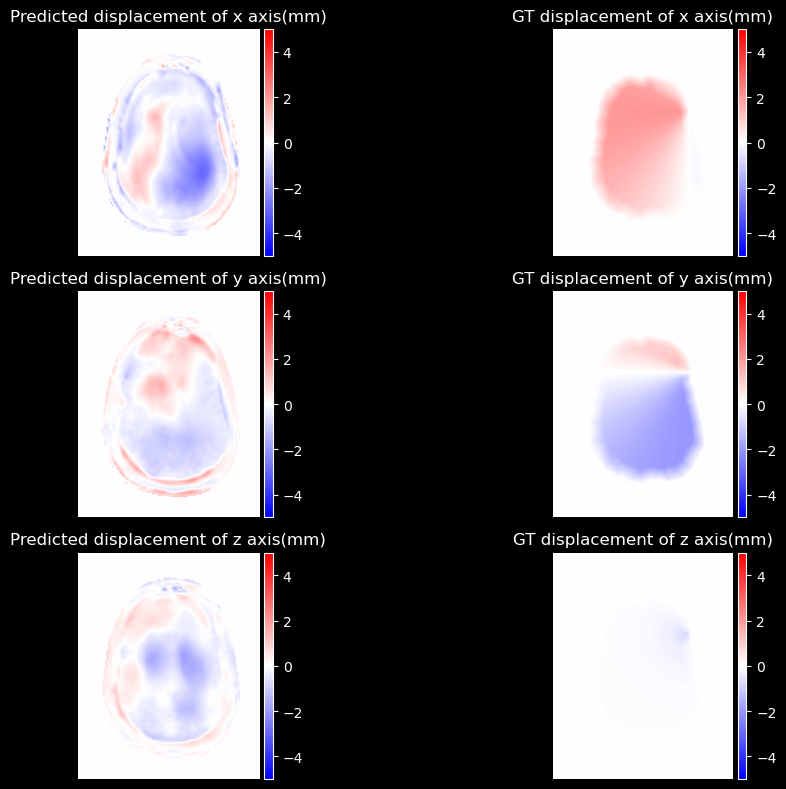

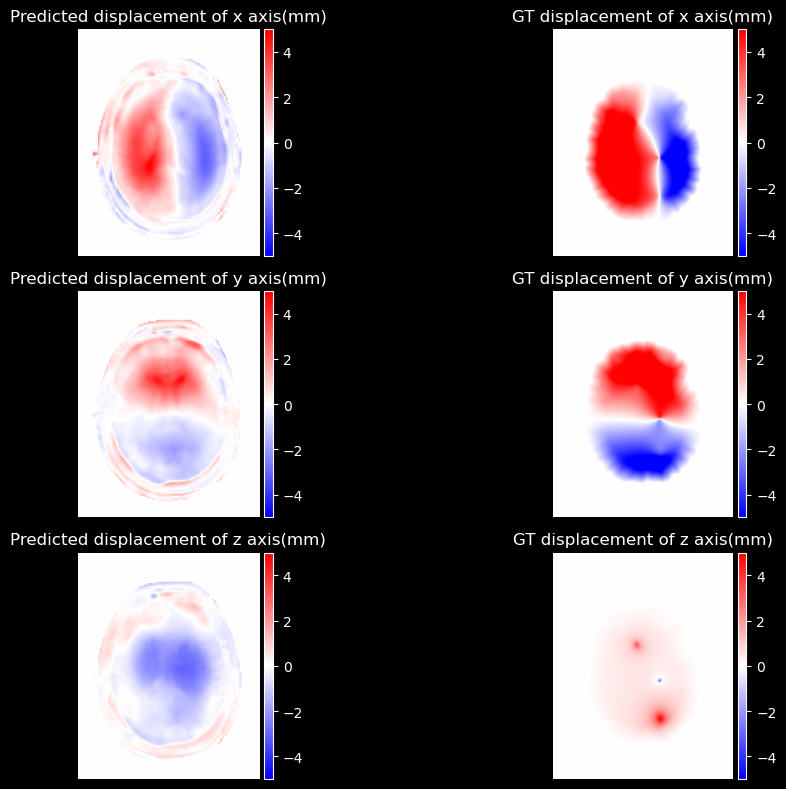

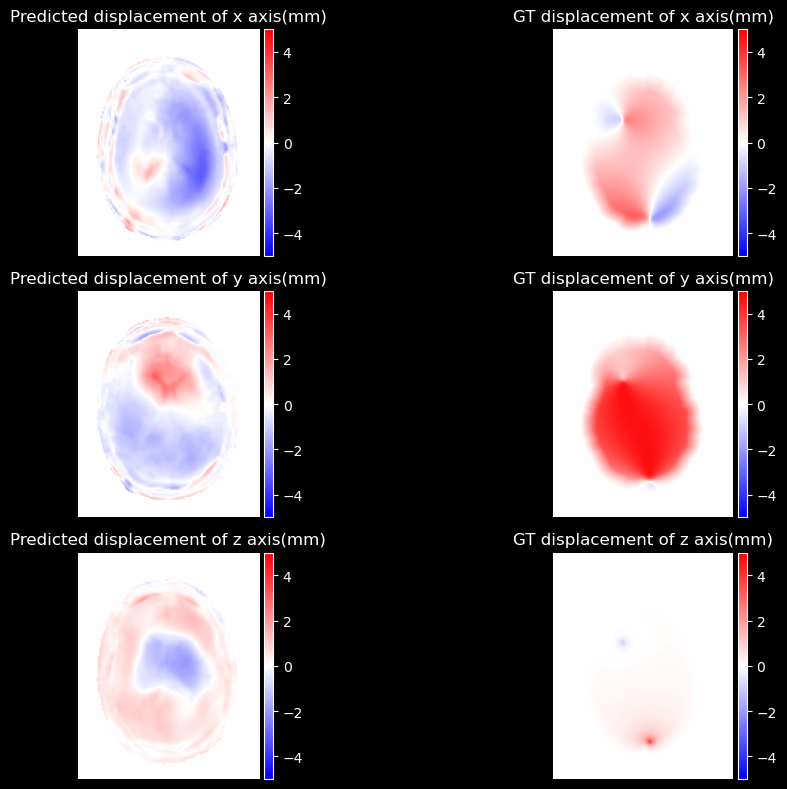

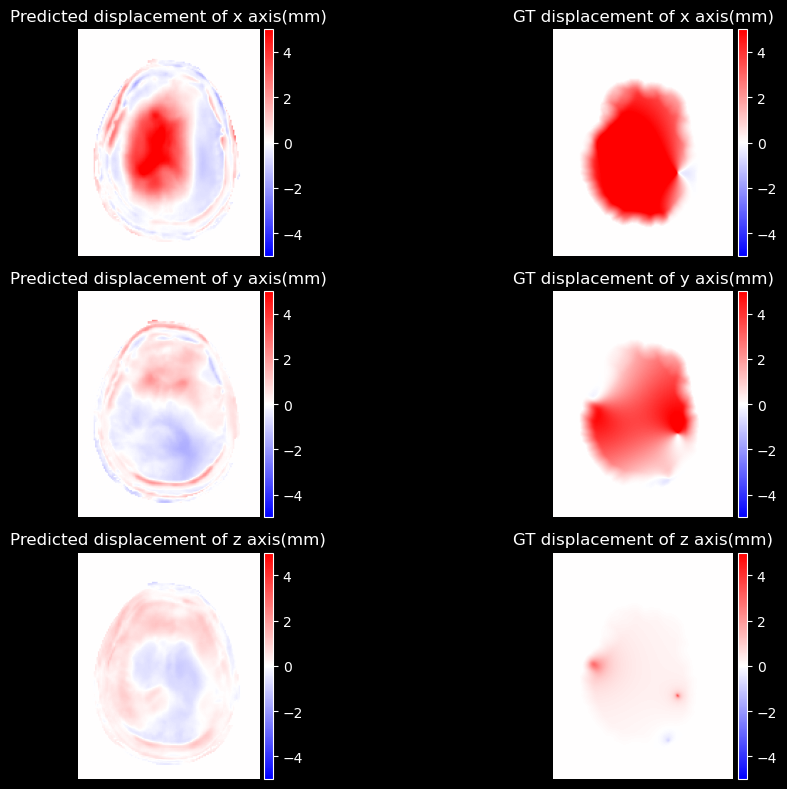

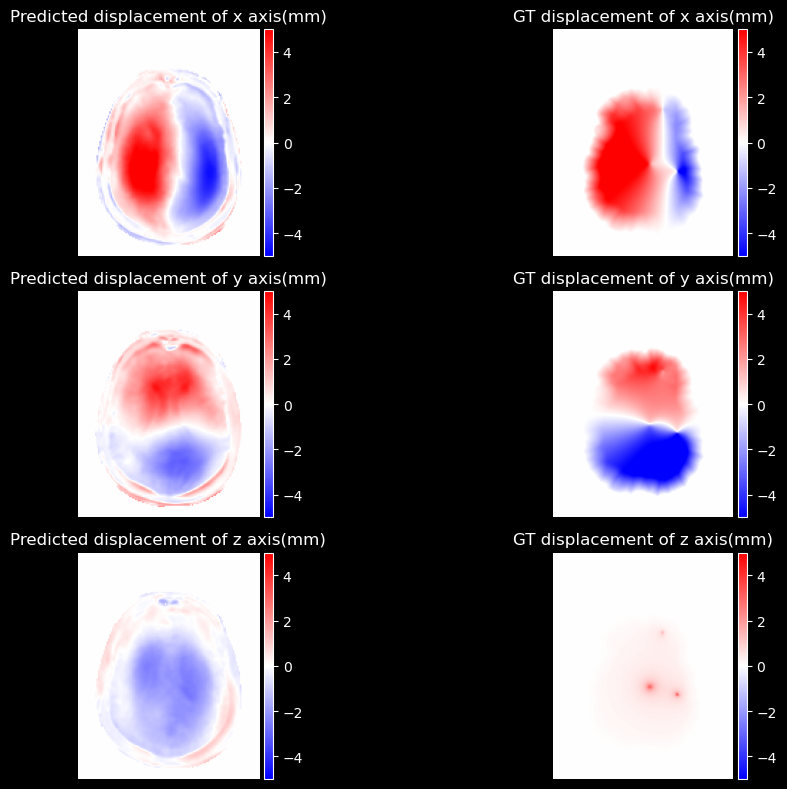

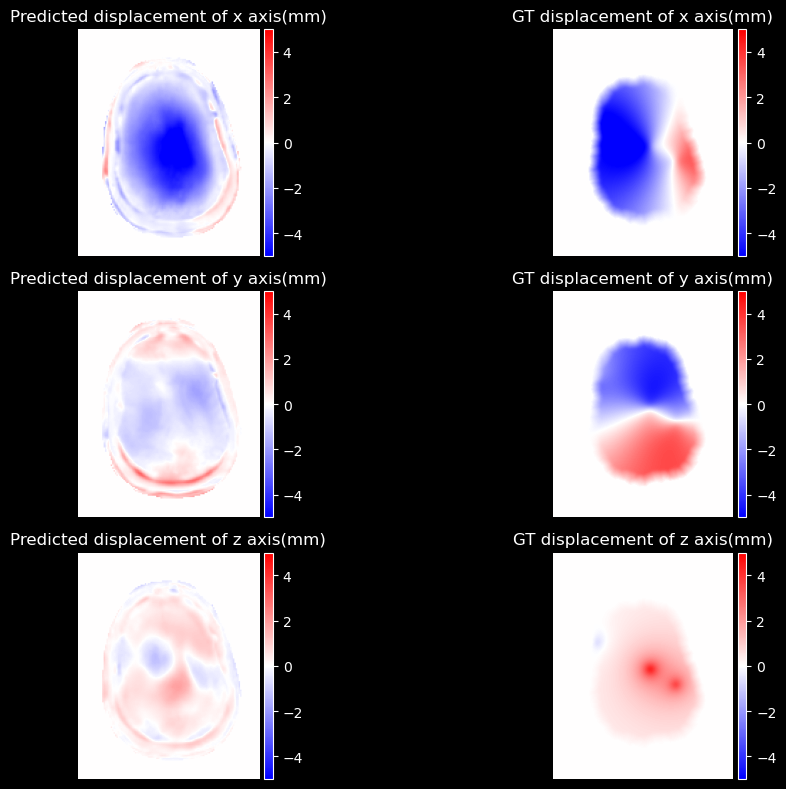

In [22]:
# how runze's prediction looks with his gt
for i in range(10):
    gt = torch.load('/home/myi16/jsr_Y/sample data/Runze/flow00'+str(i)+'.pt') # 1 270 341 183 3
    data = valid_dataset[i]
    cbct_fixed = data[0].to(device).to(device)
    mr_moving = data[1].to(device).to(device)
    ct_fixed = data[2].to(device)
    ct_moving = data[3].to(device)
    # gt = torch.from_numpy(data[-1]).to(device)
    with torch.no_grad():
        flows,_, _ = G(mr_moving, cbct_fixed)
        mr_reg = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, flows[0])
    plt.style.use('dark_background')
    islice = 72
    mask_head = (cbct_fixed[0,0,:,:,islice].cpu().numpy()>0.05).astype(int)
    fig, ax = plt.subplots(3,2,figsize=(12,8))
    np.vectorize(lambda ax: ax.axis('off'))(ax)
    pred = flows[0]
    
    imx1 = ax[0][0].imshow(1.5*pred[0,0,:,:,islice].T*mask_head.T, cmap = 'bwr',vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[0][0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imx1, cax=cax, orientation='vertical')
    ax[0][0].set_title('Predicted displacement of x axis(mm)')
    imy1 = ax[1][0].imshow(1.5*pred[0,1,:,:,islice].T*mask_head.T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[1][0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imy1, cax=cax, orientation='vertical')
    ax[1][0].set_title('Predicted displacement of y axis(mm)')
    imz1 = ax[2][0].imshow(1.5*pred[0,2,:,:,islice].T*mask_head.T, cmap = 'bwr',vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[2][0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imz1, cax=cax, orientation='vertical')
    ax[2][0].set_title('Predicted displacement of z axis(mm)')

    imx2 = ax[0][1].imshow(-0.7*gt[0,:,:,96,0].T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[0][1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imx2, cax=cax, orientation='vertical')
    ax[0][1].set_title('GT displacement of x axis(mm)')
    imy2 = ax[1][1].imshow(-0.7*gt[0,:,:,96,1].T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[1][1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imy2, cax=cax, orientation='vertical')
    ax[1][1].set_title('GT displacement of y axis(mm)')
    imz2 = ax[2][1].imshow(-gt[0,:,:,96,2].T,cmap = 'bwr', vmin=-5,vmax = 5)
    divider = make_axes_locatable(ax[2][1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imz2, cax=cax, orientation='vertical')
    ax[2][1].set_title('GT displacement of z axis(mm)')

    plt.tight_layout()
    plt.show()



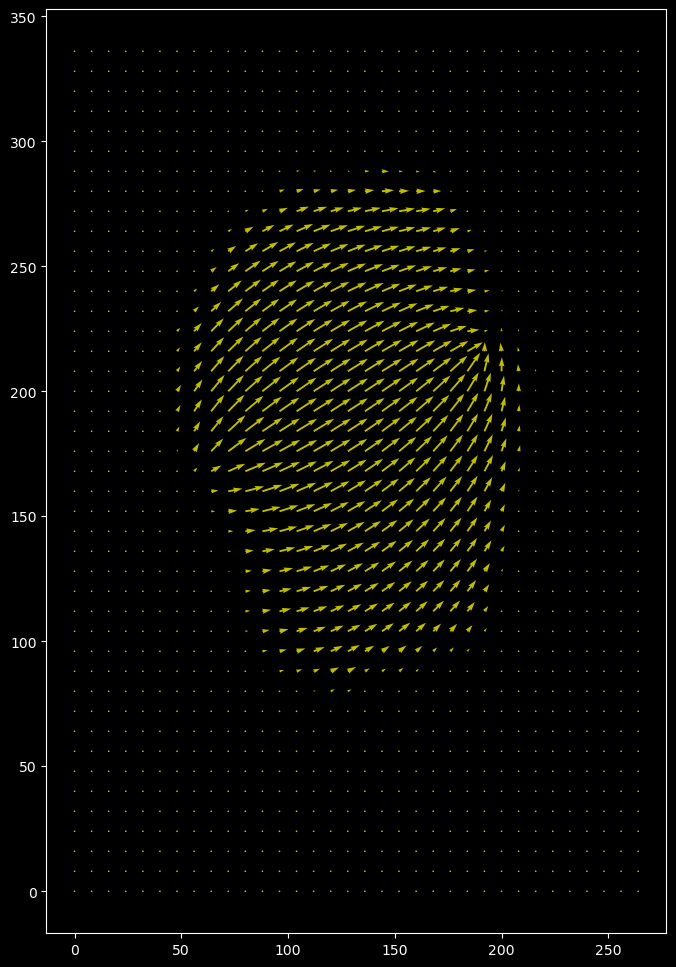

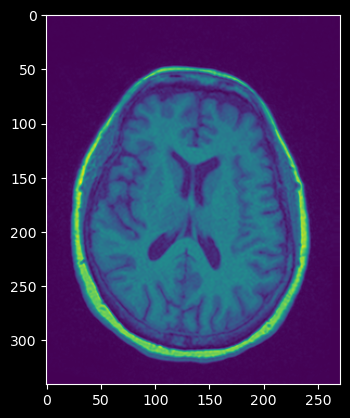

In [113]:
gt = -torch.load('/home/myi16/jsr_Y/sample data/Runze/flow00'+str(7)+'.pt') # 1 270 341 183 3
mr = torch.load('/home/myi16/jsr_Y/sample data/Runze/mr00'+str(7)+'.pt') # 1 270 341 183 3

x = np.arange(0, 270, 8)
y = np.arange(0, 341, 8)
X, Y = np.meshgrid(x, y)
U = gt[0,::8,::8,100,0].T
V = gt[0,::8,::8,100,1].T

plt.figure(figsize=(8,12))
plt.quiver(X, Y, U, V,width=0.003, color='y',angles = 'xy',scale_units='xy', scale=1)
plt.show()

plt.imshow(mr[:,:,100].T)



In [20]:
type(gt)

numpy.ndarray

In [67]:
data = valid_dataset[7]
cbct_fixed = data[0].to(device).to(device)
mr_moving = data[1].to(device).to(device)
ct_fixed = data[2].to(device)
ct_moving = data[3].to(device)
flows,_, _ = G(mr_moving, cbct_fixed)
mr_reg = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, flows[0])
pred = flows[0]
mask_head = (cbct_fixed[0,0,:,:,70].cpu().numpy()>0.05).astype(int)
shift_x = pred[0,0,:,:,:]
shift_y = pred[0,1,:,:,:]

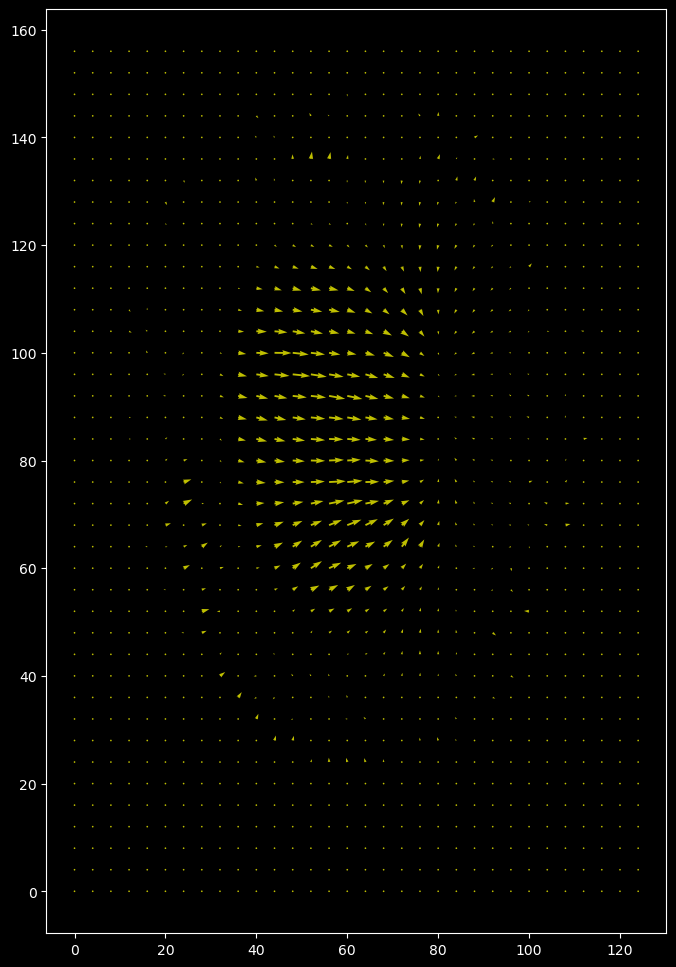

In [103]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 128, 4)
y = np.arange(0, 160, 4)
X, Y = np.meshgrid(x, y)
U = shift_x[::4,::4,70].detach().numpy()*mask_head[::4,::4]
V = shift_y[::4,::4,70].detach().numpy()*mask_head[::4,::4]

plt.figure(figsize=(8,12))
plt.quiver(X, Y, U.T, V.T, width=0.003, color='y',angles = 'xy',scale_units='xy', scale=1)
plt.show()

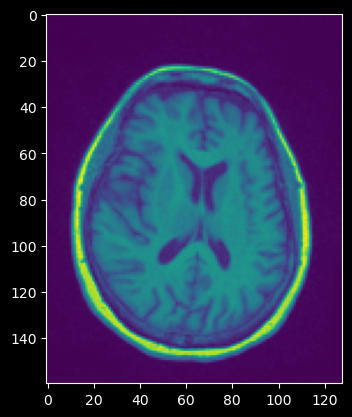

In [56]:
plt.imshow(mr_moving[0,0,:,:,70].T)

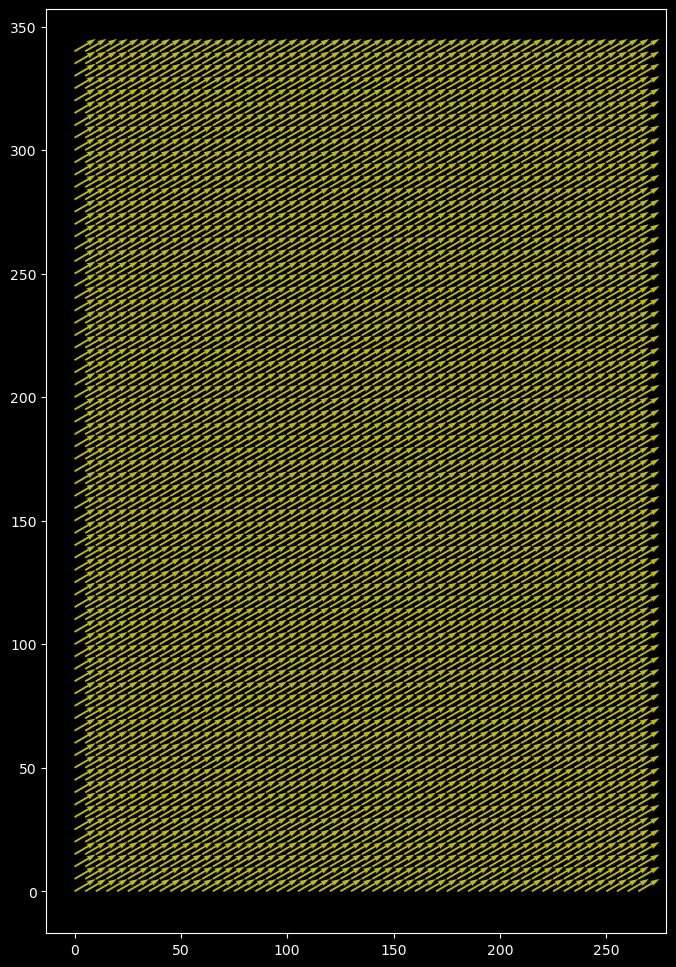

In [102]:
x = np.arange(0, 270, 5)
y = np.arange(0, 341, 5)
X, Y = np.meshgrid(x, y)
U = 10*np.ones_like(X)
V = 5*np.ones_like(Y)

plt.figure(figsize=(8,12))
plt.quiver(X, Y, U, V,width=0.003, color='y',angles = 'xy',scale_units='xy', scale=1)
plt.show()